In [1]:
# Import required packages
import numpy as np
import os
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from astropy import constants as c
from scipy.interpolate import interp1d

# Import our scripts
from pfu_transit.mask_generation import generate_exoplanet, generate_star
from pfu_transit.photometry_simulation import photometric_observation
from pfu_transit.cubic_interp import cubic_spline_interpolator, read_raw_exotic
from pfu_transit.smoothening import smoothen

In [2]:
# Load list of available exoplanet data
datasets = os.listdir("assets/exoplanet_data")
# Iterator for exoplanet_data
num = 3
# Dimensions of transit simulation
framew = 500
frameh = 500
image_scale = 3/framew

file = os.path.join("assets/exoplanet_data", datasets[num])

# Load raw data
dates_hours, flux, errs = read_raw_exotic(file)

bins, smooth_fluxes, smooth_errs = smoothen(dates_hours, flux, errs)

# Build spline from smoothened points
f = cubic_spline_interpolator(bins, smooth_fluxes)

# Interpolate data
interp_dates_hours = np.linspace(dates_hours.min(), dates_hours.max(), framew)
interp_flux = f(interp_dates_hours)
interp_errs = np.interp(interp_dates_hours, dates_hours, errs)

# Offset time to decrease mid-transit range
time_offset = np.median(interp_dates_hours)
dates_hours -= time_offset
bins -= time_offset
interp_dates_hours -= time_offset

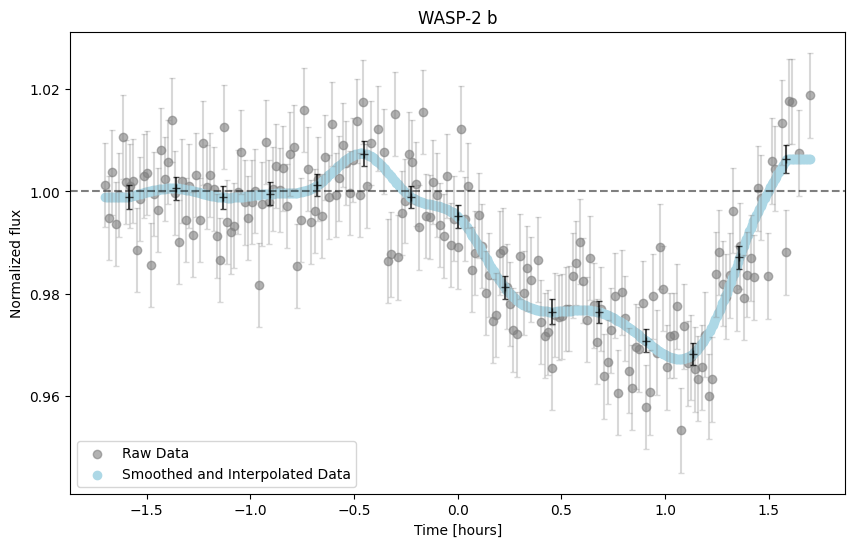

In [3]:
# Plot data
plt.figure(figsize=[10, 6])

plt.scatter(dates_hours, flux, label = 'Raw Data', alpha = .6, c = 'gray')
plt.errorbar(dates_hours, flux, errs, ls = '', alpha = 0.3, capsize=2, c = 'gray')

plt.scatter(interp_dates_hours, interp_flux, label = 'Smoothed and Interpolated Data', color="lightblue")
plt.errorbar(bins, smooth_fluxes, smooth_errs, ls = '', alpha = 0.7, capsize=2, c = 'k', marker="+")

plt.xlabel(f'Time [hours]')
plt.ylabel('Normalized flux')
plt.legend()
plt.title(f"{datasets[num][:-4]}")
plt.axhline(1, ls = '--', c = 'k', alpha = .5)

In [4]:
# Initial guesses/input parameters from database
stellar_radius = 0.84
stellar_temperature = 5180
impact_parameter = 0.749
planet_radius = 1.35
wavelength = 0.6

# Guess these parameters from the plot
transit_duration = 1.3 #hours
midtransit_offset = 0.7

# Calculated parameters for input into model
converted_impact_parameter = impact_parameter*stellar_radius
velocity = 2*stellar_radius*np.sqrt(1-impact_parameter**2)/transit_duration

start_params = (planet_radius, converted_impact_parameter, midtransit_offset, velocity)

# Define coarse grid ranges, can be made more fine later at a higher computational cost
Rp_vals  = np.linspace(planet_radius - 0.2, planet_radius + 0.2, 10) # planet radius

b_vals   = np.linspace(converted_impact_parameter-0.2,\
                                      converted_impact_parameter+0.2, 10) # impact param
midt_vals  = np.linspace(midtransit_offset-0.05, midtransit_offset+0.05, 10)      # mid_transit_time offsets
vel_vals = np.linspace(velocity-0.2, velocity+0.2, 10)   # velocity

# Create grid of parameters
param_grid = [(Rp, b, midt, vel) for Rp in Rp_vals for b in b_vals for midt in midt_vals for vel in vel_vals]
len(param_grid)

10000

In [5]:
def evaluate_params(params, t_obs, flux_obs, noise_sigma, star, image_directory = None):
    """
    params: tuple (Rp, b, wavelength, velocity)
    Returns (mse, params)
    """

    Rp, b, mid_t, velocity = params

    try:
        # build star and planet models:
        planet = generate_exoplanet(planet_radius=Rp * (c.R_jup/c.R_sun), b=b, wavelength=wavelength, no_atmosphere=True,\
                                    planet_oblateness=0, planet_rot_obliquity=0, framew=framew, frameh=frameh, image_scale=image_scale)
        t_model, flux_model = photometric_observation(star= star, planet= planet, velocity=velocity, image_scale=image_scale,\
                                                      step=1, image_directory=image_directory, threadcount=1)

        # normalize
        flux_model = flux_model/np.max(flux_model)
        t_model -= np.median(t_model)
        t_model += mid_t

        if not np.array_equal(t_model, t_obs):
            interp = interp1d(t_model, flux_model, bounds_error=False, fill_value=np.nan)
            flux_model_interp = interp(t_obs)
            # if interpolation produces NaNs - model doesnt cover full observed time - set them to baseline (1)
            nan_mask = np.isnan(flux_model_interp)
            if np.any(nan_mask):
                flux_model_interp[nan_mask] = 1.0
            flux_model = flux_model_interp

        # compute mean squared error
        mse = np.nanmean((flux_obs -  flux_model)**2)

        return mse, params
    
    except Exception as e:
        return np.inf, params       

Calculating limb darkening coefficients....


100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 1756.49it/s]


Creating mask...


100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 8591.64it/s]


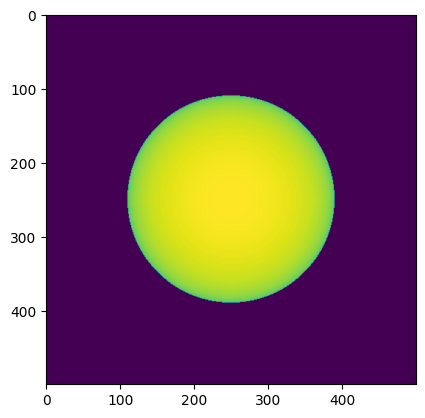

In [6]:
# Create the star
star = generate_star(wavelength=wavelength, stellar_oblateness=0, stellar_rot_obliquity=0,\
                     stellar_radius=stellar_radius, stellar_temperature=stellar_temperature, framew=framew, frameh=frameh, image_scale=image_scale)
plt.imshow(star)
plt.show()

In [7]:
# Set up multithreading
n_workers = min(12, len(param_grid))

results = []
with ThreadPoolExecutor(max_workers=n_workers) as exe:
    # Run evaluate params throughout parameter grid
    futures = [exe.submit(evaluate_params, params, interp_dates_hours, interp_flux, interp_errs, star, None)
               for params in param_grid]

    with tqdm(total=len(futures), desc="Grid search", leave=True) as pbar:
        for f in as_completed(futures):
            results.append(f.result())
            pbar.update(1)

# Find the lowest mean squared error and get parameters
results_sorted = sorted(results, key=lambda x: x[0])
best_mse, best_params = results_sorted[0]
print('Best MSE:', best_mse)
print('Best params:', best_params)

Grid search: 100%|███████████████████████████████████████████████████████████████| 10000/10000 [32:28<00:00,  5.13it/s]

Best MSE: 1.0109181704564561e-05
Best params: (1.327777777777778, 0.5180488888888888, 0.75, 1.0562443029137125)


In [14]:
best_Rp, best_b, best_midt, best_vel = best_params

# Create planet and star for best parameters
planet_best = generate_exoplanet(planet_radius=best_Rp * (c.R_jup/c.R_sun), b=best_b,\
                                 wavelength=wavelength, planet_oblateness=0, planet_rot_obliquity=0,\
                                 no_atmosphere=True, framew=framew, frameh=frameh, image_scale=image_scale)
star_best = generate_star(wavelength=wavelength, stellar_oblateness=0, stellar_rot_obliquity=0,\
                     stellar_radius=stellar_radius, stellar_temperature=stellar_temperature, framew=framew,\
                          frameh=frameh, image_scale=image_scale)

# Simulate best parameters
t_best, flux_best = photometric_observation(star_best, planet_best, velocity=best_vel,image_scale=image_scale,\
                                            image_directory=None)

# Normalize flux and offset time to mid-transit
flux_best = flux_best/np.max(flux_best)
t_best -= np.median(t_best)
t_best += best_midt

Calculating limb darkening coefficients....


100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 1523.35it/s]


Creating mask...


100%|██████████████████████████████████████████████████████████████████████████████| 455/455 [00:00<00:00, 2954.11it/s]


C:\Users\mmc\AppData\Local\Temp\ipykernel_6524\3206467556.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(t_best - best_midt, flux_best, 'r-', color="red", label="model fit", alpha=0.6)


File saved


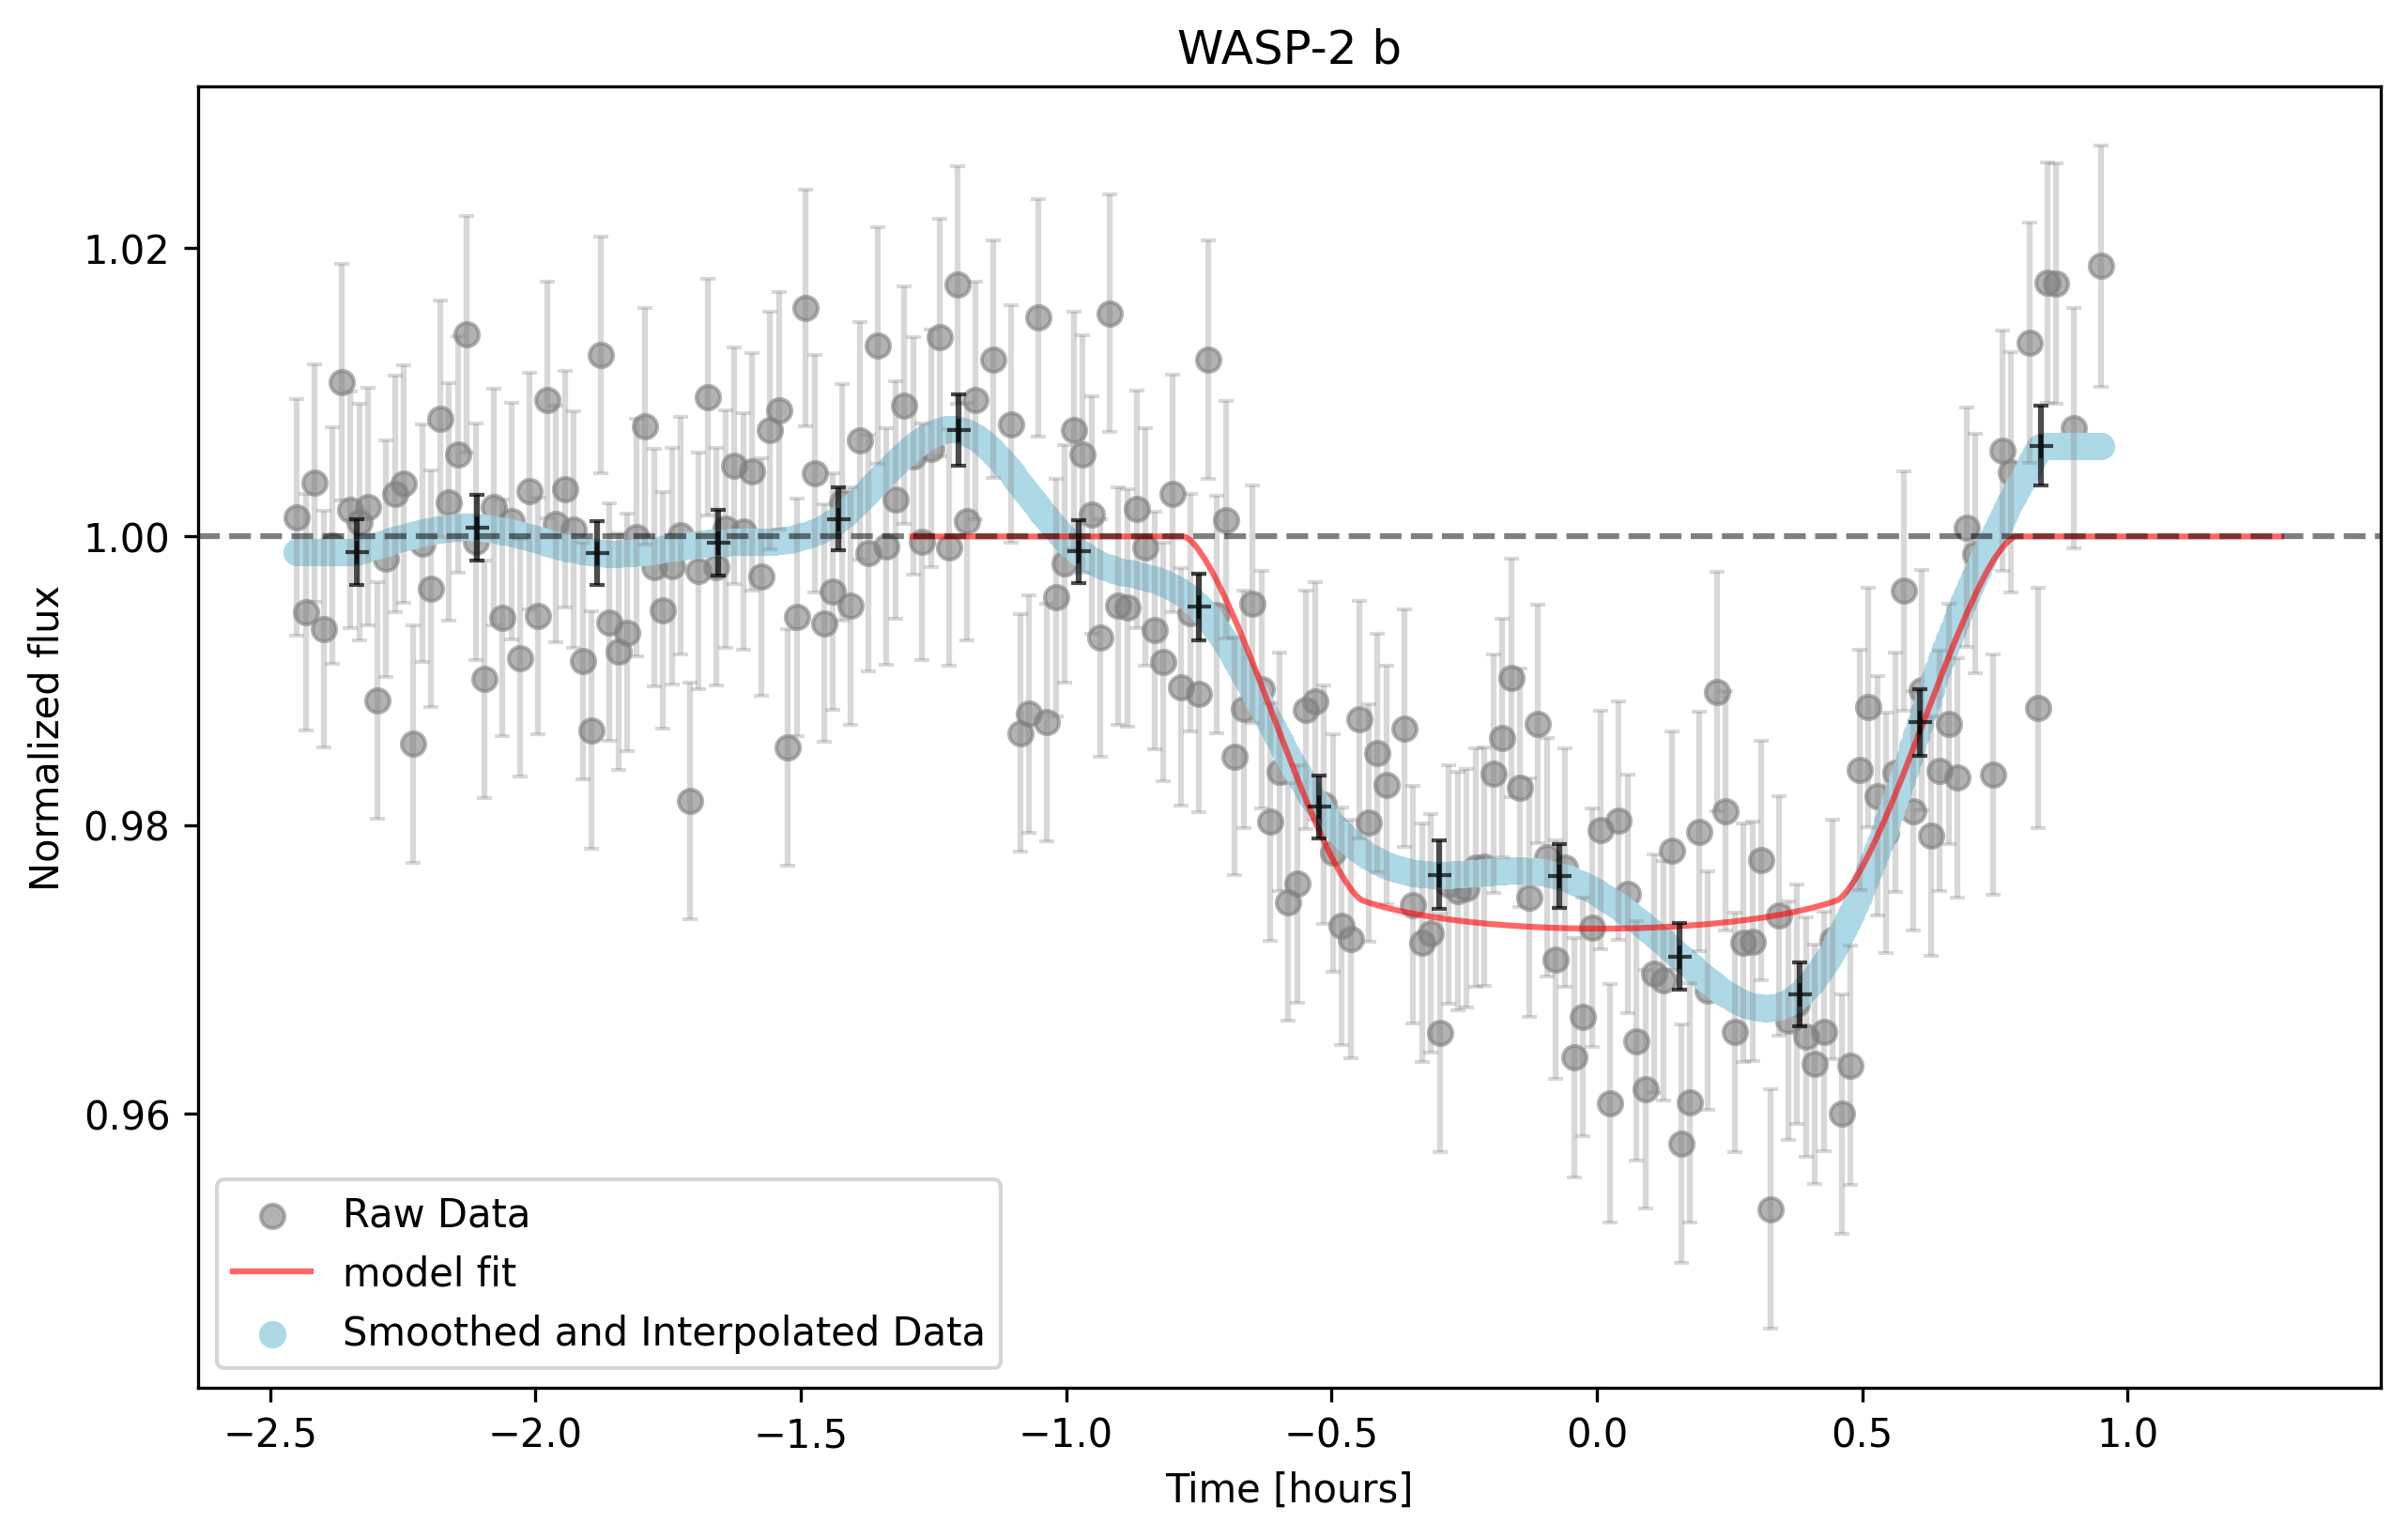

In [15]:
# Plot the fit
plt.figure(figsize=[10, 6], dpi=300)

plt.scatter(dates_hours - best_midt, flux, label = 'Raw Data', alpha = .6, c = 'gray')
plt.errorbar(dates_hours - best_midt, flux, errs, ls = '', alpha = 0.3, capsize=2, c = 'gray')
plt.plot(t_best - best_midt, flux_best, 'r-', color="red", label="model fit", alpha=0.6)
plt.scatter(interp_dates_hours - best_midt, interp_flux, label = 'Smoothed and Interpolated Data', color="lightblue")
plt.errorbar(bins - best_midt, smooth_fluxes, smooth_errs, ls = '', alpha = 0.7, capsize=2, c = 'k', marker="+")

plt.xlabel(f'Time [hours]')
plt.ylabel('Normalized flux')
plt.legend()
plt.title(f"{datasets[num][:-4]}")
plt.axhline(1, ls = '--', c = 'k', alpha = .5)

# Save the data
np.savez(f"{datasets[num][:-4]}"+"_params", dates_hours + time_offset, flux, errs, bins + time_offset,\
         smooth_fluxes, smooth_errs, interp_dates_hours + time_offset, interp_flux, interp_errs,\
         t_best + time_offset, flux_best, best_Rp, best_b, best_midt - time_offset, best_vel)
print("File saved")


# Printing params

In [13]:
import numpy as np

exoplanet_info = {}

path = 'assets/fitted_params'
exoplanets = ['qatar6', 'tres2', 'tres5', 'wasp52', 'wasp2']
arrays = [11, 12, 13, 14]
params = {1: 'radius  ', 2: 'impact  ', 3: 'midtime ', 4: 'velocity'}

for exoplanet in exoplanets:
    exoplanet_info[exoplanet] = {}
    print(f"{exoplanet}:")
    i = 1
    for array in arrays:
        total_path = f"{path}/{exoplanet}/arr_{array}.npy"
        print(f"    {params[i]}: {np.load(total_path):.3f}")
        exoplanet_info[exoplanet][params[i]] = np.load(total_path)
        i+=1
        



qatar6:
    radius  : 1.171
    impact  : 0.711
    midtime : -2.156
    velocity: 0.648
tres2:
    radius  : 1.311
    impact  : 0.920
    midtime : -2.854
    velocity: 0.719
tres5:
    radius  : 1.378
    impact  : 0.414
    midtime : -1.644
    velocity: 0.986
wasp52:
    radius  : 1.192
    impact  : 0.541
    midtime : -2.182
    velocity: 0.969
wasp2:
    radius  : 1.328
    impact  : 0.518
    midtime : -0.949
    velocity: 1.056


In [ ]:
exoplanet_info['qatar6']['stellar_radius'] = 0.785
exoplanet_info['tres2']['stellar_radius']  = 1.016
exoplanet_info['tres5']['stellar_radius']  = 0.911
exoplanet_info['wasp52']['stellar_radius'] = 
exoplanet_info['wasp2']['stellar_radius']  =

{'qatar6': {'radius  ': array(1.17111111),
  'impact  ': array(0.71145222),
  'midtime ': array(-2.15629788),
  'velocity': array(0.64789482)},
 'tres2': {'radius  ': array(1.31111111),
  'impact  ': array(0.92010667),
  'midtime ': array(-2.85395395),
  'velocity': array(0.71877964)},
 'tres5': {'radius  ': array(1.37777778),
  'impact  ': array(0.41395889),
  'midtime ': array(-1.64352363),
  'velocity': array(0.98550779)},
 'wasp52': {'radius  ': array(1.19222222),
  'impact  ': array(0.54066667),
  'midtime ': array(-2.18189604),
  'velocity': array(0.96939891)}}